In [215]:
import pickle

import torch
from torchvision.transforms import v2 as transforms

import numpy as np
from ultralytics import YOLO
from ultralytics.engine.results import Boxes

from keyrover import *
from keyrover.datasets import *
from keyrover.vision import *
from keyrover.color import image_color
from keyrover.ml import get_device, TexCoordsRegressionModel

In [100]:
device = get_device()

In [101]:
SIZE = (256, 256)

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(*get_dataset_norm_params(version=3))
])

In [102]:
with open(f"{RAW_TEXCOORDS}/key_texcoords_mean.bin", "rb") as file:
    U_means = pickle.load(file)
    V_means = pickle.load(file)

palette = []
palette_to_cls = {}

for (cls, u), (_, v) in zip(U_means.items(), V_means.items()):
    palette.append([u, v])
    palette_to_cls[(u, v)] = cls

palette = np.array(palette)

In [103]:
ARCH = "unet"
BACKBONE = "timm-regnetx_004"
name = "brisk-plant-1"

model = TexCoordsRegressionModel(ARCH, BACKBONE, in_channels=3, out_classes=2, lr=0.0, activation="tanh")
model.load_state_dict(torch.load(f"models/texcoords/{name}-{ARCH}-{BACKBONE}.pt", weights_only=True))
model.to(device)
model.eval()

yolo = YOLO("models/yolo/train4/weights/best.pt")


0: 320x320 70 keys, 16.2ms
Speed: 0.8ms preprocess, 16.2ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)


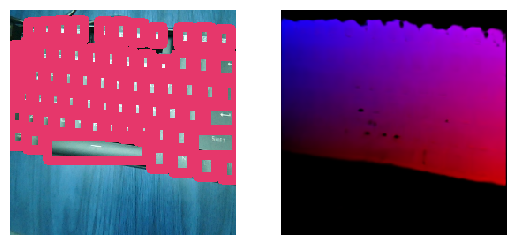

In [348]:
img = cv2.imread(f"{TEST_DATASET}/0.jpg")
img = cv2.resize(img, SIZE)
pred = yolo.predict(img, conf=0.25, iou=0.3)[0]
keyboard_mask = model.predict(transform(img))
keyboard_mask = reorder_image_axes(keyboard_mask)

out = plot_yolo(pred, scale=1, draw_text=False, plot=False)
imshow(out, keyboard_mask)

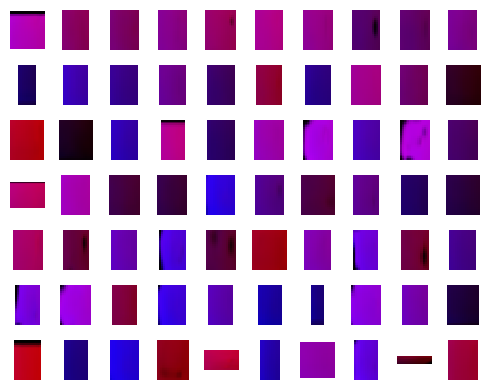

In [349]:
img = pred.orig_img

keys = [crop_rect(keyboard_mask, box) for box in pred.boxes]
colors = np.array([color * 256 for key in keys if (color := image_color(key)) is not None])
show_images(keys, figsize=(5, 4))

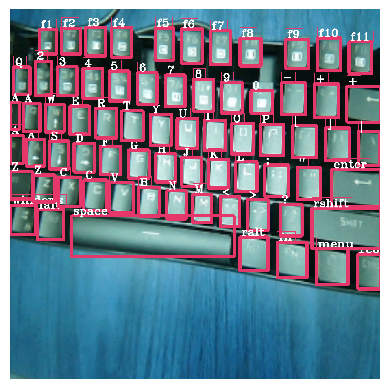

In [350]:
# Unfiltered classification algorithm

classes = [palette_to_cls[tuple(color)] for color in to_palette(colors, palette)]
labels = [id_to_key[cls] for cls in classes]

plot_predictions(pred.orig_img, pred.boxes, labels, font_size=0.25, line_width=0, scale=5)

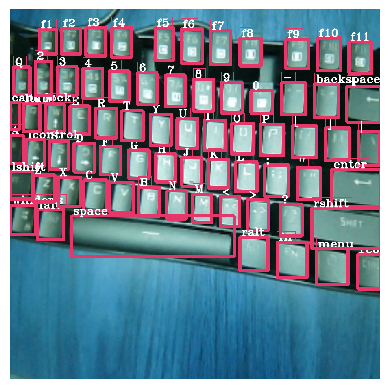

In [351]:
# Greedy classification algorithm

n = colors.shape[0]
m = palette.shape[0]

color_matrix = np.repeat(colors[:, np.newaxis], m, axis=1)
dist = np.linalg.norm(color_matrix - palette, axis=-1)
labels = [None] * n

for _ in range(n):
    index = np.unravel_index(dist.argmin(), dist.shape)
    closest_color = palette[index[1]]
    closest_key = palette_to_cls[tuple(closest_color)]

    labels[index[0]] = id_to_key.get(closest_key)
    dist[index[0]] = float("inf")
    dist[:, index[1]] = float("inf")

plot_predictions(pred.orig_img, pred.boxes, labels, font_size=0.25, line_width=0, scale=5)

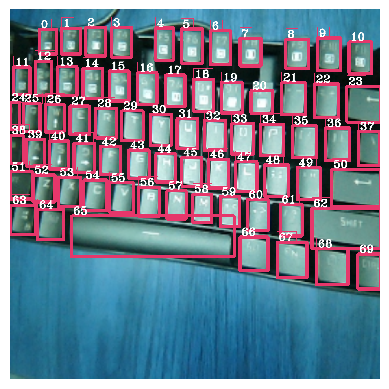

In [372]:
class Box:
    def __init__(self, box, n: int):
        self.x, self.y, self.w, self.h = map(float, box.xywh[0])
        self.n = n

        self.box = box

    def __sub__(self, other):
        return np.array([self.x - other.x, self.y - other.y])

    def __repr__(self):
        return f"Box({self.x:.2f}, {self.y:.2f}, n={self.n})"

    def norm(self) -> float:
        return (self.x ** 2 + self.y ** 2) ** 0.5

    area = property(lambda self: self.w * self.h)
    xyxy = property(lambda self: self.box.xyxy)


def sort_boxes(boxes):
    sorted_boxes = []
    
    while len(boxes):
        a = sorted(boxes, key=lambda p: p.x + p.y)[0]  # top-left box
        b = sorted(boxes, key=lambda p: p.x - p.y)[-1]  # top-right box

        u = b - a  # normalized direction vector
        u /= np.linalg.norm(u)

        row = []
        remaining = []

        for box in boxes:
            distance = abs(np.cross(box - a, u))  # distance between box and line a->b
            (row if distance < 10 else remaining).append(box)  # todo better threshold

        sorted_boxes.extend(sorted(row, key=lambda h: h.x))
        boxes = remaining
    
    return sorted_boxes


boxes = sort_boxes([Box(box, i) for i, box in enumerate(pred.boxes)]) 
plot_predictions(pred.orig_img, boxes, range(len(boxes)), font_size=0.25, line_width=0, scale=5)